In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import imageio.v3 as iio


In [ ]:
# Cell: Run S2/PSD on PNG (or TIFF)

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

# If you haven't installed these in your venv kernel:
# %pip install -q numpy matplotlib tifffile imageio pillow

import tifffile as tiff
import imageio.v3 as iio


def find_project_root(start: Path | None = None) -> Path:
    """Find nearest parent containing 'pictures' folder."""
    p = (start or Path.cwd()).resolve()
    for cur in [p, *p.parents]:
        if (cur / "pictures").exists():
            return cur
    return p


def read_image_any(path: Path) -> np.ndarray:
    """Read .tif/.tiff via tifffile; other formats via imageio."""
    path = Path(path)
    ext = path.suffix.lower()
    if ext in {".tif", ".tiff"}:
        img = tiff.imread(str(path))
    else:
        img = iio.imread(path)

    img = np.asarray(img)
    if img.ndim == 3 and img.shape[-1] == 4:  # RGBA -> RGB
        img = img[..., :3]
    return img


def rgb_to_gray(img: np.ndarray) -> np.ndarray:
    """RGB -> grayscale float32."""
    img = np.asarray(img)
    if img.ndim == 2:
        return img.astype(np.float32, copy=False)
    if img.ndim == 3 and img.shape[-1] >= 3:
        r, g, b = img[..., 0], img[..., 1], img[..., 2]
        return (0.2126 * r + 0.7152 * g + 0.0722 * b).astype(np.float32, copy=False)
    raise ValueError(f"Unsupported image shape: {img.shape}")


def otsu_threshold(x: np.ndarray) -> float:
    """Otsu threshold for 2D grayscale."""
    x = x.astype(np.float32, copy=False)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0
    lo, hi = float(x.min()), float(x.max())
    if hi <= lo:
        return lo

    hist, edges = np.histogram(x, bins=256, range=(lo, hi))
    hist = hist.astype(np.float64)
    p = hist / np.maximum(hist.sum(), 1.0)
    omega = np.cumsum(p)
    centers = (edges[:-1] + edges[1:]) / 2.0
    mu = np.cumsum(p * centers)
    mu_t = mu[-1]
    sigma_b2 = (mu_t * omega - mu) ** 2 / (omega * (1.0 - omega) + 1e-12)
    idx = int(np.nanargmax(sigma_b2))
    return float(centers[idx])


def fft_autocorr_unbiased(f: np.ndarray, pad: bool = True) -> np.ndarray:
    """
    Unbiased autocorrelation via FFT.
    pad=True reduces wrap-around artifacts by zero-padding.
    """
    f = np.asarray(f, dtype=np.float32)
    if f.ndim != 2:
        raise ValueError("f must be 2D")

    h, w = f.shape
    if pad:
        H, W = 2 * h, 2 * w
        fp = np.zeros((H, W), dtype=np.float32)
        fp[:h, :w] = f
        ones = np.zeros((H, W), dtype=np.float32)
        ones[:h, :w] = 1.0
    else:
        fp = f
        ones = np.ones_like(f, dtype=np.float32)

    F = np.fft.fft2(fp)
    auto = np.fft.ifft2(F * np.conj(F)).real

    O = np.fft.ifft2(np.fft.fft2(ones) * np.conj(np.fft.fft2(ones))).real
    auto /= np.maximum(O, 1e-12)

    return auto[:h, :w]


def radial_average(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Radial average around image center (expects fftshifted input)."""
    h, w = img.shape
    cy, cx = (h - 1) / 2.0, (w - 1) / 2.0
    y, x = np.indices((h, w))
    r = np.sqrt((y - cy) ** 2 + (x - cx) ** 2).astype(np.float32)

    r_int = r.astype(np.int32)
    max_r = int(r_int.max())

    sums = np.bincount(r_int.ravel(), weights=img.ravel(), minlength=max_r + 1)
    cnts = np.bincount(r_int.ravel(), minlength=max_r + 1)
    prof = sums / np.maximum(cnts, 1)

    return np.arange(max_r + 1, dtype=np.float32), prof.astype(np.float32)


@dataclass(frozen=True)
class Results:
    r_px: np.ndarray
    s2_r: np.ndarray
    k_idx: np.ndarray
    psd_k: np.ndarray
    phi: float


def analyze_image(
    path: Path,
    outdir: Path,
    mode: str = "binary_black",   # <-- PNG 二值图建议用这个 (for PNG with black objects on white background, use this)
    invert: bool = False,
    pad: bool = True,
) -> Results:
    """
    mode:
      - binary_black: assume black objects on white background (black=1)
      - binary_otsu:  grayscale -> Otsu -> mask
      - gray_centered: grayscale -> mean-center -> autocov C
    """
    outdir.mkdir(parents=True, exist_ok=True)

    img = read_image_any(path)
    x = rgb_to_gray(img)

    if invert:
        x = x.max() - x

    if mode == "binary_black":
        thr = 0.5 * (float(x.min()) + float(x.max()))  # robust for near-binary PNG
        f = (x < thr).astype(np.float32)  # black=1
        phi = float(f.mean())
        s2 = fft_autocorr_unbiased(f, pad=pad)
        s2c = np.fft.fftshift(s2)
        r_px, s2_r = radial_average(s2c)
        y_label = "S2(r)"
        s2_tag = "S2"
    elif mode == "binary_otsu":
        thr = otsu_threshold(x)
        f = (x >= thr).astype(np.float32)
        phi = float(f.mean())
        s2 = fft_autocorr_unbiased(f, pad=pad)
        s2c = np.fft.fftshift(s2)
        r_px, s2_r = radial_average(s2c)
        y_label = "S2(r)"
        s2_tag = "S2"
    elif mode == "gray_centered":
        g = x - float(np.mean(x))
        phi = float(np.mean(x))
        c = fft_autocorr_unbiased(g, pad=pad)
        cc = np.fft.fftshift(c)
        r_px, s2_r = radial_average(cc)
        y_label = "C(r)"
        s2_tag = "C"
    else:
        raise ValueError("Unknown mode")

    # PSD from mean-centered grayscale
    g = x - float(np.mean(x))
    G = np.fft.fft2(g)
    psd = (np.abs(G) ** 2).astype(np.float32)
    psdc = np.fft.fftshift(psd)
    k_idx, psd_k = radial_average(psdc)

    s2_csv = outdir / f"{path.stem}_{s2_tag}_radial.csv"
    psd_csv = outdir / f"{path.stem}_PSD_radial.csv"
    np.savetxt(s2_csv, np.c_[r_px, s2_r], delimiter=",", header="r_px,profile", comments="")
    np.savetxt(psd_csv, np.c_[k_idx, psd_k], delimiter=",", header="k_index,psd", comments="")

    plt.figure()
    plt.plot(r_px, s2_r)
    plt.xlabel("r (pixels)")
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.savefig(outdir / f"{path.stem}_{s2_tag}.png", dpi=200)
    plt.show()

    plt.figure()
    plt.plot(k_idx, psd_k)
    plt.xlabel("radial frequency index")
    plt.ylabel("Power spectrum (radial avg)")
    plt.tight_layout()
    plt.savefig(outdir / f"{path.stem}_PSD.png", dpi=200)
    plt.show()

    print("Loaded:", path, "shape/dtype:", img.shape, img.dtype)
    print("Saved:", s2_csv)
    print("Saved:", psd_csv)
    if mode.startswith("binary"):
        print(f"Mask area fraction phi = {phi:.4f}")

    return Results(r_px=r_px, s2_r=s2_r, k_idx=k_idx, psd_k=psd_k, phi=phi)





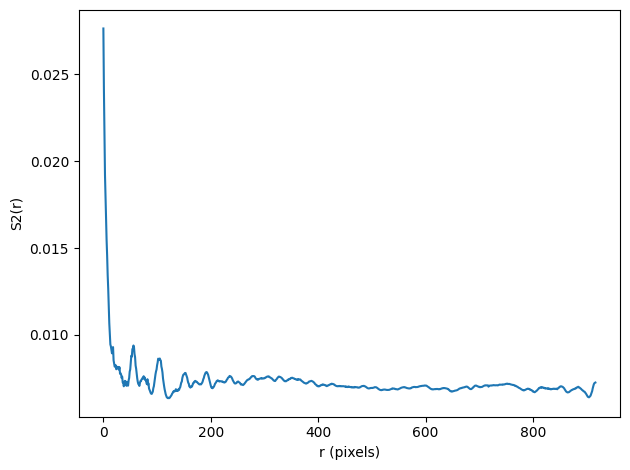

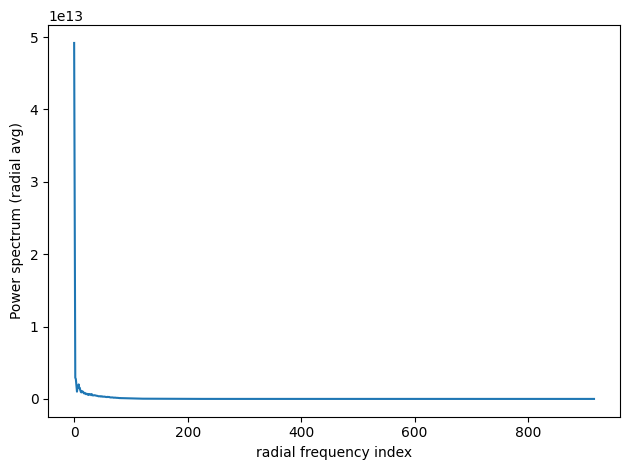

Loaded: C:\Users\qq187\Downloads\cancerpicture\scripts\run_pic\pictures\260558_1(highlight1).png shape/dtype: (1144, 1434, 3) uint8
Saved: C:\Users\qq187\Downloads\cancerpicture\scripts\run_pic\run_pic\260558_1(highlight1)_S2_radial.csv
Saved: C:\Users\qq187\Downloads\cancerpicture\scripts\run_pic\run_pic\260558_1(highlight1)_PSD_radial.csv
Mask area fraction phi = 0.0919


In [ ]:
# ---- RUN ----
root = find_project_root()
img_path = root / "pictures" / "260558_1(highlight1).png"   # <-- 改成你的 PNG 文件名 change this to your PNG filename
outdir = root / "run_pic"

res = analyze_image(
    path=img_path,
    outdir=outdir,
    mode="binary_black",   # PNG 已经是黑点白底：用这个最准(this is for PNG with black objects on white background)
    invert=False,          # 如果你的是白点黑底，改 True(if your PNG has white objects on black background, set this to True)
    pad=True,
)


phi (black area fraction) = 0.027634 (~2.76%)
phi^2 = 0.000764
S2 tail plateau ~ 0.006935
Approx correlation length (1/e, detrended) ~ 8.0 px


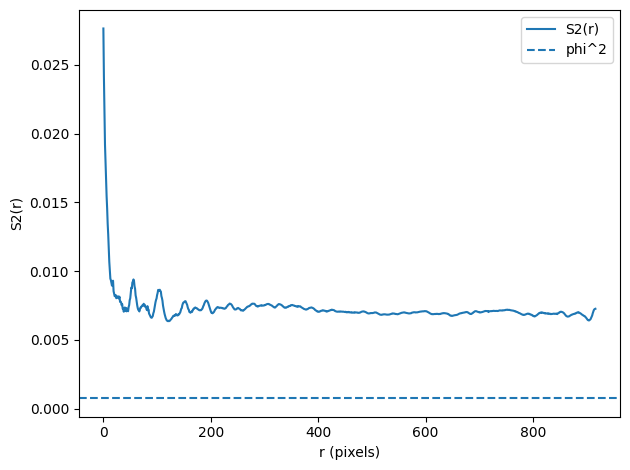

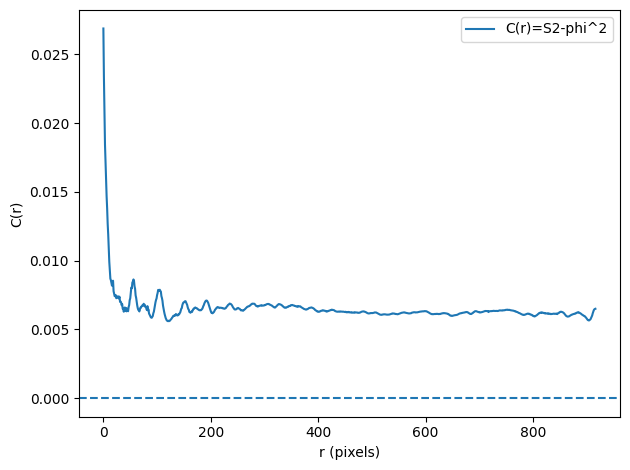

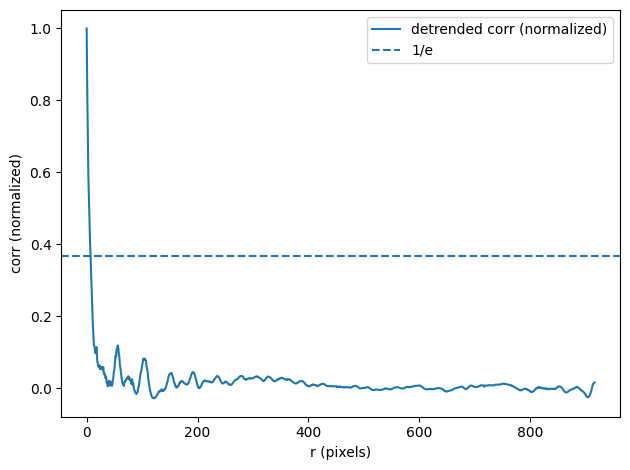

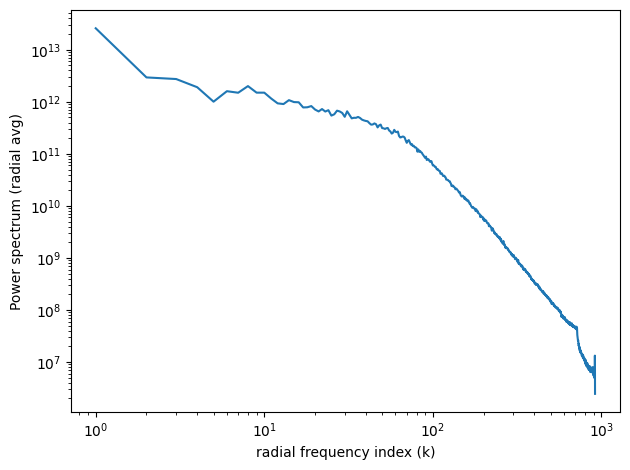

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

s2_csv = Path("run_pic") / "260558_1(highlight1)_S2_radial.csv"  # <-- 改成你的 S2 CSV 文件名 change this to your S2 CSV filename
psd_csv = Path("run_pic") / "260558_1(highlight1)_PSD_radial.csv" # <-- 改成你的 PSD CSV 文件名 change this to your PSD CSV filename

r, S2 = np.loadtxt(s2_csv, delimiter=",", skiprows=1).T
k, P  = np.loadtxt(psd_csv, delimiter=",", skiprows=1).T

phi = float(S2[0])
phi2 = phi**2

# connected correlation (should -> 0 for stationary fields)
C = S2 - phi2

# Optional: remove long-range plateau using tail mean (helps estimate "feature-scale" length)
tail = float(S2[-200:].mean())
C_detrend = S2 - tail
C_detrend /= max(C_detrend[0], 1e-12)

# 1/e correlation length estimate (after detrend)
target = 1/np.e
idx = np.where(C_detrend <= target)[0]
r_corr = float(r[idx[0]]) if idx.size else float("nan")

print(f"phi (black area fraction) = {phi:.6f} (~{phi*100:.2f}%)")
print(f"phi^2 = {phi2:.6f}")
print(f"S2 tail plateau ~ {tail:.6f}")
print(f"Approx correlation length (1/e, detrended) ~ {r_corr:.1f} px")

plt.figure()
plt.plot(r, S2, label="S2(r)")
plt.axhline(phi2, linestyle="--", label="phi^2")
plt.xlabel("r (pixels)")
plt.ylabel("S2(r)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(r, C, label="C(r)=S2-phi^2")
plt.axhline(0, linestyle="--")
plt.xlabel("r (pixels)")
plt.ylabel("C(r)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(r, C_detrend, label="detrended corr (normalized)")
plt.axhline(1/np.e, linestyle="--", label="1/e")
plt.xlabel("r (pixels)")
plt.ylabel("corr (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.loglog(k[1:], P[1:])  # skip k=0
plt.xlabel("radial frequency index (k)")
plt.ylabel("Power spectrum (radial avg)")
plt.tight_layout()
plt.show()

root = find_project_root()

outdir = root / "run_pic"
